In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports & Initialization

In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
%matplotlib inline

import os
import sys
from collections import defaultdict

import wandb

from sklearn.metrics import mean_squared_error, log_loss, confusion_matrix, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

from pygam import LogisticGAM, s, te

from colorama import Style, Fore
from cycler import cycler

import warnings; warnings.filterwarnings('ignore')

sys.path.append('..')
from config import CFG
CFG = CFG()
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', CFG.NCOLS)
pd.set_option('display.max_rows', CFG.NROWS)

In [3]:
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
grn = Style.BRIGHT + Fore.GREEN
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

palette = ['#3c3744', '#048BA8', '#EE6352', '#E1BB80', '#78BC61']
grey_palette = ['#8e8e93', '#636366', '#48484a', '#3a3a3c', '#2c2c2e', '#1c1c27']
bg_color = '#F6F5F5'
white_color = '#d1d1d6'

custom_params = {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.left': False,
    'grid.alpha':0.2,
    'figure.figsize': (16, 6),
    'axes.titlesize': 'large',
    'axes.labelsize': 'large',
    'ytick.labelsize': 'medium',
    'xtick.labelsize': 'medium',
    'legend.fontsize': 'large',
    'lines.linewidth': 1,
    'axes.prop_cycle': cycler('color',palette),
    'figure.facecolor': bg_color,
    'figure.edgecolor': bg_color,
    'axes.facecolor': bg_color,
    'text.color':grey_palette[1],
    'axes.labelcolor':grey_palette[1],
    'axes.edgecolor':grey_palette[1],
    'xtick.color':grey_palette[1],
    'ytick.color':grey_palette[1],
    'figure.dpi':150,
}
sns.set_theme(
    style='whitegrid',
    palette=sns.color_palette(palette),
    rc=custom_params)

# Helper Functions

In [4]:
def show_confusion_roc(oof: list) -> None:
    """
    Draws a confusion matrix and roc_curve with AUC score.
    """
    f, ax = plt.subplots(1, 2, figsize=(13.3, 4))
    df = pd.DataFrame(np.concatenate(oof), columns=['id', 'preds', 'target']).set_index('id')
    df.index = df.index.astype(int)
    cm = confusion_matrix(df.target, df.preds.ge(0.5).astype(int))
    ax[0].grid(False)
    RocCurveDisplay.from_predictions(df.target, df.preds, color=palette[1], ax=ax[1])
    plt.tight_layout()

# Loading Data & Feature Engineering

In [5]:
train = pd.read_csv(os.path.join(CFG.PROCESSED_DATA, 'train.csv'))
test = pd.read_csv(os.path.join(CFG.PROCESSED_DATA, 'test.csv'))

In [6]:
def log_(column):
    return np.log(-np.min(column) + 1 + column)

train[['Log_EK', 'Log_EK_DMSNR_Curve']] = train.apply({'EK': log_, 'EK_DMSNR_Curve': log_})
test[['Log_EK', 'Log_EK_DMSNR_Curve']] = test.apply({'EK': log_, 'EK_DMSNR_Curve': log_})

train = train.drop(['EK', 'EK_DMSNR_Curve'], axis=1)
test = test.drop(['EK', 'EK_DMSNR_Curve'], axis=1)

In [7]:
{c:train.columns.get_loc(c) for c in train.drop('Class', axis=1).columns}

{'Mean_Integrated': 0,
 'SD': 1,
 'Skewness': 2,
 'Mean_DMSNR_Curve': 3,
 'SD_DMSNR_Curve': 4,
 'Skewness_DMSNR_Curve': 5,
 'Log_EK': 7,
 'Log_EK_DMSNR_Curve': 8}

In [50]:
params = {
    'terms': 
        s(0, n_splines=CFG.SPLINES) +
        s(1, n_splines=CFG.SPLINES) +
        s(2, n_splines=30) +
        s(3, n_splines=CFG.SPLINES) + 
        s(4, n_splines=CFG.SPLINES) +
        s(5, n_splines=CFG.SPLINES) +
        s(6, n_splines=CFG.SPLINES) +
        s(7, n_splines=CFG.SPLINES) +
        te(2, 5) +
        te(1, 4) +
        te(6, 7),
    'lam': 0.20
         }

In [51]:
X, y = train.drop('Class', axis=1), train.Class
cv = StratifiedKFold(n_splits=CFG.NFOLDS, shuffle=True, random_state=CFG.SEED)

models_ = []
val_scores = []
tr_scores = []
oof = pd.Series(0, index=train.index)

for fold, (tr_idx, val_idx) in enumerate(cv.split(X, y)):
    if (fold + 1) % 5 == 0 or (fold + 1) == 1:
        print(f'{grn} Fold {fold + 1} of {CFG.NFOLDS}{res}')

    X_tr = X.iloc[tr_idx]
    X_val = X.iloc[val_idx]
    y_tr = y.iloc[tr_idx]
    y_val = y.iloc[val_idx]

    model = LogisticGAM(**params).fit(X_tr, y_tr)

    val_preds = model.predict_proba(X_val)
    val_score = log_loss(y_val, val_preds)

    tr_preds = model.predict_proba(X_tr)
    tr_score = log_loss(y_tr, tr_preds)

    print(f'\t\t\t{gld}Train LogLoss:{blu}{tr_score:.5f}{res}\t\t{gld}Val Logloss:{blu}{val_score:.5f}{res}')

    # Stores out-of-fold preds.
    oof.loc[val_idx] = val_preds

    # Stores the model
    models_.append(model)
    val_scores.append(val_score)
    tr_scores.append(tr_score)
    
train_ll = np.mean(np.array(tr_scores))
val_ll = np.mean(np.array(val_scores))
print(f'\n\n{gld}Average Train Logloss:\t{blu}{train_ll:.5f}')
print(f'{gld}Average Val Logloss:\t{blu}{val_ll:.5f}')

 Fold 1 of 10
			Train LogLoss:0.03103		Val Logloss:0.02632
			Train LogLoss:0.03064		Val Logloss:0.02986
			Train LogLoss:0.03047		Val Logloss:0.03166
			Train LogLoss:0.02991		Val Logloss:0.03656
 Fold 5 of 10


In [20]:
md = defaultdict(list)
for i in range(8):
    csum, psum = 0, 0
    for model in models_:
        pdep, confi = model.partial_dependence(term=i, width=.95)
        csum += confi
        psum += pdep
    md[str(i)].append((csum/len(models_), psum/len(models_)))

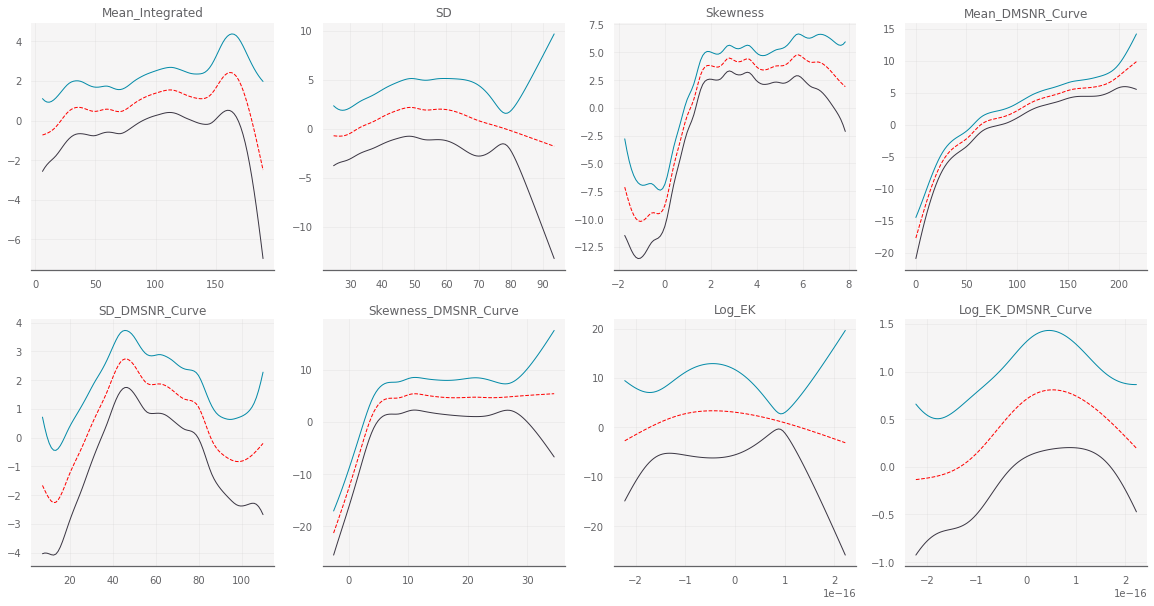

In [37]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
titles = list(test.columns)

for i, ax in enumerate(axs.ravel()):
    XX = model.generate_X_grid(term=i)
    pdep, confi = md[str(i)][0]

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

In [38]:
def plot3d(gam, idx, interactions):
    XX = gam.generate_X_grid(term=idx, meshgrid=True)
    Z = gam.partial_dependence(term=idx, X=XX, meshgrid=True)

    title_idx = idx % 8
    title = interactions[title_idx]

    fig = go.Figure(data=[go.Surface(z=Z, x=XX[0], y=XX[1])])
    fig.update_layout(title=title, autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
    fig.show()

In [39]:
interactions = [f'{test.columns[x]} + {test.columns[y]}' for x, y in [(2, 5), (1, 4), (6, 7)]]



In [40]:
plot3d(model, 9, interactions)

In [42]:
plot3d(model, 10, interactions)

In [43]:
plot3d(model,8, interactions)

In [44]:
model.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                    100.3198
Link Function:                        LogitLink Log Likelihood:                                 -3172.7629
Number of Samples:                       105808 AIC:                                             6546.1654
                                                AICc:                                            6546.3615
                                                UBRE:                                               2.0626
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.9033
Feature Function                  Lam

In [48]:
preds = np.sum(model.predict_proba(test) for model in models_) / len(models_)

In [49]:
submission = pd.read_csv(os.path.join(CFG.DATA_PATH, 'sample_submission.csv'))
submission['Class'] = preds
submission.to_csv(
    os.path.join(CFG.BASE_PATH, 'submissions', 'GAM_v1.csv'),
    index=False)